# Account for all integers using 2n, 2n+1, 4n+1 and (n-1)/2, n/2, W(n), ...




In [269]:
import sys, io
import math
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from fractions import Fraction
from sympy import factorint
from itertools import product
from sympy.ntheory import factorint
from typing import List, Optional, Tuple
from Levenshtein import distance

In [243]:
"""
Code from previous notebooks,

TODO: Remove unneed functions not needed for mrTup representation

"""

def T(n):
    """ Compute next value in simplified Collatz sequence.
    """
    if n & 1 == 0:
        return n//2
    else:
        return (3*n + 1)//2
#
def L_T(n):
    """ Compute binary label-string for a given Collatz number
    """
    if n == 1:
        return "1"

    S = ""
    while n != 1:
        if n & 1 == 0:
            n = n//2
            S = S + "1"
        else:
            n = (3*n + 1)//2
            S = S + "0"
    return S
#
def Ay_L(L):
    """ Generate A matrix and y vector from label string
    """
    rank = len(L) + 2    
    A = np.zeros((rank,rank))
    y = np.zeros((rank))
    for row in range(rank-3):
        if L[row-2] == "0":
            a_val = -1.0
            y_val = 0.0
        else:
            a_val = -3.0
            y_val = 1.0
        A[row][row] = a_val
        A[row][row+1] = 2.0
        y[row] = y_val
    #
    # Last 3 rows are always the same
    row = rank - 3
    A[row][row] = -1
    A[row][row+1] = 2
    y[row] = 0
    row = rank - 2
    A[row][row] = -3
    A[row][row+1] = 2
    y[row] = 1
    row = rank - 1
    A[row][row] = 1
    A[row][row-2] = -1
    y[row] = 0
    
    return A, y
#
def solve_Ay_L(L):
    """ Solve for the x vector given the label-string
    """
    A, y = Ay_L(L)
    return A, np.linalg.solve(A, y), y
#
def x0_L(L):
    """ Get the x[0] value given a label-string
    """
    A, x, y = solve_Ay_L(L)
    return round(x[0])  # clean up mantisa garbage
#

def countZeros(label):
    zero_count = 0
    for bit in label:
        if bit == "0":
            zero_count += 1
    return zero_count
#

def Z(L):
    """ Indexes of zeros in label string
    """
    for i in range(len(L)):
        if L[i] == "0":
            yield i
#
def a_b_c_L(L):
    """ Get the (power-of-two, power-of-three, zero-sum-accumulator) tuple for a node given its label
    """
    a = len(L)
    b = 0
    for bit in L:
        if bit == "0":
            b += 1
    ZZ = [(j,i) for j, i in enumerate(Z(L))]
    c = sum((3 ** (b - j - 1)) * (2 ** (i)) for j, i in ZZ)
    S = [zz[1] for zz in ZZ]
    return (a,b,c,S)
#
def val_a_b_c(a_b_c):
    """ Get the value for a node given the tuple (power-of-two, power-of-three, zero-sum-accumulator)
    """
    a, b, c = a_b_c
    f = Fraction( ((2**a) - c), (3**b) )
    return (f.numerator, f.denominator)
#
def val_a_b_c_L(a_b_c_L):
    a_b_c = a_b_c_L[0:3]
    return val_a_b_c(a_b_c)
#
def val_L(L):
    """ Get the value for a node given the label string
    """
    return val_a_b_c_L(a_b_c_L(L))
#
def collatzPath(collatzNumber):
    path = []
    if collatzNumber < 1:
        return None
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#

def collatzPath2(n_d_tup, truncate_at=100):
    """
    Collatz Path for rationals with loop detection and "too long" cut-off
    """
    chain = [n_d_tup]
    path = []
    governor = truncate_at
    while n_d_tup != (1, 1):
        if (n_d_tup[0] & 1) == 0:
            n_d_tup = (n_d_tup[0]//2, n_d_tup[1])
            path.append("1")
        else:
            f = Fraction((3 * n_d_tup[0] + n_d_tup[1])//2, n_d_tup[1])
            n_d_tup = (f.numerator, f.denominator)
            path.append("0")
        if n_d_tup in chain:
            path.insert(0,"↺")
            break
        
        governor -= 1
        if governor == 0:
            path.insert(0,"∀")
            break
        #
        chain.append(n_d_tup)
    #
    return ("".join(path), chain)
#

    
#
#  Mixed Radix form and functions
#

N_i = ((0,0), [])

def mr_TupItemValue(a_b, a_0):
    a,b = a_b
    val = (2**a)*(3**(a_0 + b))
    # print(f"val {a_b}*(3**{a_0}) = {val}")
    return val
#
def mrTupValue(mr_tup):
    # Multiplying the numerator by 3 ** the generation keeps us in integer land
    a_0 = mr_tup[0][0]
    total = mr_TupItemValue(mr_tup[0], a_0)
    for a_b in mr_tup[1]:
        total -= mr_TupItemValue(a_b, a_0)
    frac = Fraction(total, 3**a_0)
    return (frac.numerator, frac.denominator)
#

"""
F_0, F_1 build the binary lattice starting from N_i
"""
def F_0(mr_tup):
    return ( (mr_tup[0][0]+1, mr_tup[0][1]-1), mr_tup[1] + [(mr_tup[0][0], -(len(mr_tup[1])+1))] )
#
def F_1(mr_tup):
    return ((mr_tup[0][0]+1, mr_tup[0][1]), mr_tup[1])
#

"""
G_0, G_1 work from the other side of the label prepending to the label
"""
def G_0(mr_tup):
    return ( (mr_tup[0][0]+1, mr_tup[0][1]-1), [(0,-1)] + [(c+1, d-1) for (c, d) in mr_tup[1]] )
#
def G_1(mr_tup):
    return ((mr_tup[0][0]+1, mr_tup[0][1]), [(c+1, d) for (c, d) in mr_tup[1]])
#

"""
THIS GIVES THE COLLATZ CHAIN !!!
"""
def G_rev(mr_tup):
    """ Reverse of either G_0 or G_1, uses contents of L list to determine COA
    """
    u_tup, v_list = mr_tup
    a,b = u_tup
    a_ = a-1
    b_ = b
    if len(v_list) > 0:
        if v_list[0][0] == 0 and v_list[0][1] == -1:
            # Then we are undoing a G_0 ...
            b_ = b+1
            if len(v_list) == 1:
                v_list = []
            else:
                v_list = [(c-1, d+1) for (c, d) in mr_tup[1][1:]]
        else:
            v_list = [(c-1, d) for (c, d) in mr_tup[1]]
    return ((a_, b_), v_list)
#

def mrTupFromPath(label):
    mr_tup = N_i
    for bit in label:
        if bit == "1":
            mr_tup = F_1(mr_tup)
        else:
            mr_tup = F_0(mr_tup)
    return mr_tup
#
def mrTupToPath(T):
    """
    Convert mrTup to node label
    The T[1] list encodes the positions of the zeros in the numerator power of two values
    """
    S = ["1"] * T[0][0]
    for j in range(len(T[1])):
        S[(T[1][j][0])] = "0" 
    return "".join(S)
#

def mrTupFromValue(n):
    label = collatzPath(n)
    return mrTupFromPath(label)
#

def strip_01(label):
    while len(label) > 2 and label[-2:] == "01":
        label = label[0:-2]
    return label
#
def canonicalLabel(label):
    return strip_01(label)
#

LABEL_RX = re.compile('^(?P<prefix>.*?)((?P<inttag>111)(?P<tail>((01)*)))$')

def split_int_label(s):
    """
    Splits label into 3 parts and returns prefix and suffix if matches integer-candidate pattern
    """
    match = LABEL_RX.search(s)
    if match:
        return (match.group('prefix'), match.group('tail'))
    else:
        return None  # or raise an error if preferred
#

def generationLabels(a):
    if a == 0:
        return ""
    seqs = product('10', repeat=(a))
    for bit_tup in seqs:
        label = "".join(bit_tup)
        yield label
#
def generationTups(a):
    for label in generationLabels(a):
        mrTup = mrTupFromPath(label)
        yield (label, mrTup, mrTupValue(mrTup))
    
def generationIntCandidateLabels(a):
    seqs = product('10', repeat=(a))
    for bit_tup in seqs:
        label = "".join(bit_tup)
        head_tail = split_int_label(label)
        if head_tail:
            # return int candidate with stripped tail
            yield head_tail[0] + "111"
#

def mrIntTupsForGeneration(aa):
    for label in generationIntCandidateLabels(aa):
        mrTup = mrTupFromPath(label)
        yield (label, mrTup, mrTupValue(mrTup))
#
def generationGenNums(a):
    vals = []
    bb = 3**(a)
    for infoTup in generationTups(a):
        _, __, val_tup = infoTup
        vals.append(val_tup[0] * (bb//val_tup[1]))
    vals.sort(reverse=True)
    for idx, val in enumerate(vals):
        if idx < len(vals) - 1:
            delta = val - vals[idx+1]
        else:
            delta = None
        print(f'{val}\t{delta}')
#        
def generationPairGenNums(a):
    vals = []
    bb = 3**(a+1)
    for infoTup in generationTups(a):
        _, __, val_tup = infoTup
        vals.append(val_tup[0] * (bb//val_tup[1]))
    for infoTup in generationTups(a+1):
        _, __, val_tup = infoTup
        vals.append(val_tup[0] *  (bb//val_tup[1]))
    vals.sort(reverse=True)
    for idx, val in enumerate(vals):
        if idx < len(vals) - 1:
            delta = val - vals[idx+1]
        else:
            delta = None
        print(f'{val}\t{delta}')
#
def mr2Nplus_1(T):
    B = len(T[1])  
    L = [(0, -1)]

    # Keep initial zeros
    idx = 0
    for idx, val in enumerate(T[1]):
        if T[1][idx][0] != idx:
            break
        L.append( (T[1][idx][0] + 1, T[1][idx][1]-1) )
    # Remove the first tuple where (a, -a) is true
    match = False
    for i in range(idx, B, 1):
        if (not match) and (T[1][i][0] == -T[1][i][1]):
            match = True
        else:
            L.append( (T[1][i][0]+1, T[1][i][1]) )
    if not match:
        return None
    return ( (T[0][0] + 1, T[0][1]), L)
#

def splitOutInitialZeros(L):
    """ In the Easy mr2Nplus_1 algorithm, any initial label zeros counting sequentially up 
        from i == 0 and the 2 exponent being i are handles separately from zeros that follow
        the first 1,
    """
    L_a = []
    L_z = []
    initial = True
    for i in range(len(L)):
        if initial and L[i][0] == i:
            L_a.append(L[i])
        else:
            initial = False
            L_z.append(L[i])
    return L_a, L_z
#

        

def lattice2N_plus1_pairs(a):
    """
    For a given depth in the tree, generate all 2n+1 pairs in the tree
    """
    seqs = product('10', repeat=(a))
    for bit_tup in seqs:
        label = "".join(bit_tup)
        label = strip_01(label)
        val = mrTupValue(mrTupFromPath(label))
        f = Fraction(2 * val[0] + 1, val[1])
        val_ = (f.numerator, f.denominator)
        label_, chain_ = collatzPath2(val_)
        if (len(label_) == 0):
            d = len(label)
        elif label_[0] in ["↺", "∀"]:
            d = 100 + len(label)
        else:
            d = distance(label, label_)
        yield (len(label), d, (val, label), (val_, label_))
#



In [277]:
def mrTupToLaTex(T):
    a, b = T[0]
    s = "\\frac{2^{%d}}{3^{%d}}"%(a, -b)
    L = T[1]
    if len(L) > 0:
        s = s + " - ( "
        plus = "  "
        for c_d in L:
            c, d = c_d
            t = "\\frac{2^{%d}}{3^{%d}}"%(c, -d)
            s = s + plus + t
            plus = " + "
        s = s + " )"
    return "$ " + s + " $"
#

In [244]:
val = (27, 1)
((val[0] - 1)//2, val[1])

(13, 1)

In [245]:
def mrTupEqual(Ta, Tb):
    if (Ta[0] != Tb[0]):
        return False
    if len(Ta[1]) != len(Tb[1]):
        return False
    for i in range(len(Ta[1])):
        if Ta[1][i] != Tb[1][i]:
            return False
    return True
#

In [246]:
def mr2Nplus_1_inv(T):
    """ Inverse function of mr2Nplus_1
    """
    val = mrTupValue(T)
    f = Fraction((val[0] - 1)//2, val[1])
    val_goal_ = (f.numerator, f.denominator)
    a, b = T[0]
    a_ = a - 1
    b_ = b
    L_a, L_z =  splitOutInitialZeros(T[1])

    if len(L_a) == 0:
        # Input cannot be an output of mr2Nplus_1
        # print("len(L_a) == 0")
        return None
    L_a_ = [(c_d[0] - 1, c_d[1] + 1) for c_d in L_a[1:] ]
    L_z_ = [(c_d[0] - 1, c_d[1]) for c_d in L_z ]

    # We know a zero was removed in a limited range ... find the one that gives the correct value
    zero_options = []
    if len(L_a_) == 0:
        a_min = 0
    else:
        a_min = L_a_[-1][0]+1
    if len(L_z_) == 0:
        a_max = T[0][0]-2 # cannot be in last three 1's
    else:
        a_max = L_z_[0][0]
    for k in range(a_min, a_max, 1):
        zero_options.append((k, -k))

    if len(zero_options) == 0:
        # print("len(zero_options) == 0")
        return None
    
    if len(zero_options) == 1:
        T_ = ((a_, b_), L_a_ + zero_options + L_z_)
        val_ = mrTupValue(T_)
        if val_ != val_goal_:
            print("Something is wrong")
            print((T, "->", T_))
            return None
        return T_
    else:
        for k_k in zero_options:
            T_ = ((a_, b_), L_a_ + [k_k] + L_z_)
            val_ = mrTupValue(T_)
            # print(f"    val_ with {L_a_} {k_k} {L_z_} is {val_}")
            if val_ == val_goal_:
                return T_

    # print("Failed to find (k,k)")
    return None
#
            

In [6]:
for i in range(5, 100):
    T = mrTupFromValue(i)
    T_ = mr2Nplus_1(T)
    #print(f"{T} >>>>2n+1>>>> {T_}")
    if T_ is not None:
        TT = mr2Nplus_1_inv(T_)
        val_ = mrTupValue(TT)
        if val_ != (i, 1):
            print(f"Error: {T}({i}) != {TT}({val_})")
        print(f"success reversing mr2Nplus_1(mrTupFromValue({i}))")
    else:
        print(f"2n+1 not applicable to {i}")
#


2n+1 not applicable to 5
success reversing mr2Nplus_1(mrTupFromValue(6))
success reversing mr2Nplus_1(mrTupFromValue(7))
2n+1 not applicable to 8
success reversing mr2Nplus_1(mrTupFromValue(9))
success reversing mr2Nplus_1(mrTupFromValue(10))
success reversing mr2Nplus_1(mrTupFromValue(11))
2n+1 not applicable to 12
2n+1 not applicable to 13
success reversing mr2Nplus_1(mrTupFromValue(14))
2n+1 not applicable to 15
2n+1 not applicable to 16
success reversing mr2Nplus_1(mrTupFromValue(17))
success reversing mr2Nplus_1(mrTupFromValue(18))
2n+1 not applicable to 19
2n+1 not applicable to 20
2n+1 not applicable to 21
success reversing mr2Nplus_1(mrTupFromValue(22))
2n+1 not applicable to 23
2n+1 not applicable to 24
success reversing mr2Nplus_1(mrTupFromValue(25))
success reversing mr2Nplus_1(mrTupFromValue(26))
success reversing mr2Nplus_1(mrTupFromValue(27))
2n+1 not applicable to 28
2n+1 not applicable to 29
success reversing mr2Nplus_1(mrTupFromValue(30))
success reversing mr2Nplus_1(m

In [275]:
def checkTupEasy(label):
    T = mrTupFromPath(label)
    TT = mr2Nplus_1(T)
    if TT is not None:
        return True
    else:
        return False
#

In [8]:
# No label = "11+" lattice nodes are "easy" and only 2 -> 5 is somewhat neighborly
for i in range(0, 20):
    val = 2*(2**i) + 1
    tup_2n_plus1 =  mrTupFromValue(val)    
    print ((i, val, mrTupToPath(tup_2n_plus1), tup_2n_plus1))

(0, 3, '00111', ((5, -2), [(0, -1), (1, -2)]))
(1, 5, '0111', ((4, -1), [(0, -1)]))
(2, 9, '0100010110111', ((13, -6), [(0, -1), (2, -2), (3, -3), (4, -4), (6, -5), (9, -6)]))
(3, 17, '010110111', ((9, -3), [(0, -1), (2, -2), (5, -3)]))
(4, 33, '010100110010110111', ((18, -8), [(0, -1), (2, -2), (4, -3), (5, -4), (8, -5), (9, -6), (11, -7), (14, -8)]))
(5, 65, '0101011100010110111', ((19, -8), [(0, -1), (2, -2), (4, -3), (8, -4), (9, -5), (10, -6), (12, -7), (15, -8)]))
(6, 129, '01010100011000010100100010000101100010010000001100001110101011101100011110111', ((77, -44), [(0, -1), (2, -2), (4, -3), (6, -4), (7, -5), (8, -6), (11, -7), (12, -8), (13, -9), (14, -10), (16, -11), (18, -12), (19, -13), (21, -14), (22, -15), (23, -16), (25, -17), (26, -18), (27, -19), (28, -20), (30, -21), (33, -22), (34, -23), (35, -24), (37, -25), (38, -26), (40, -27), (41, -28), (42, -29), (43, -30), (44, -31), (45, -32), (48, -33), (49, -34), (50, -35), (51, -36), (55, -37), (57, -38), (59, -39), (63, -40

In [9]:
mrTupFromPath("11111"), mrTupValue(mrTupFromPath("11111"))



(((5, 0), []), (32, 1))

In [10]:
PARTS_RX_tail = re.compile('^(?P<head>[01]*?)((?P<inttag>(111)?)(?P<tail>((01)*)))$')
PARTS_RX_head = re.compile('^(?P<prefix>0*)(?P<ones>1*)(?P<thezero>0?)(?P<remainder>[01]*)$')
RULE1_RX = re.compile('^(?P<prefix>0*)(?P<ones>1+)(?P<thezero>0)(?P<remainder>[01]*)((?P<inttag>111)(?P<tail>((01)*)))$')

In [11]:
def mrTupLabelParts(label):
    match_tail = PARTS_RX_tail.search(label)
    if match_tail:
        match_head = PARTS_RX_head.search(match_tail.group('head'))
        if match_head:
            P = (match_head.group('prefix'), match_head.group('ones'), match_head.group('thezero'), match_head.group('remainder'), match_tail.group('inttag'), match_tail.group('tail'))
    else:
        P = ("","","",label, "", "")
    return P
#

In [12]:
def genEasy2n_plus_1(a):
    """
    Generate all "easy" 2n+1 mrTups
    """
    if a <= 5:
        yield None
    else:
        for label in generationLabels(a):
            T = mrTupFromPath(label)
            val = mrTupValue(T)
            if val[1] == 1:
                did_match = False
                match = RULE1_RX.search(label)
                if match:
                    if a <= 12:
                        print((match.group('prefix'), match.group('ones'), match.group('thezero'), match.group('remainder'), match.group('inttag'), match.group('tail')))
                    did_match = True
                    T_ = mr2Nplus_1(T)
                    if T_ is None:
                        print("EASY NOT EASY:")
                        print((val[0], label))
                    else:
                        val_ = mrTupValue(T_)
                        if  val_[1] != 1 or val_[0] != (2*val[0] + 1):
                            print("EASY NOT EASY -- check fail:")
                            print((val[0], label))
                yield((label, val, did_match))
#

In [13]:
def generationIntLabels(a):
    for label in generationLabels(a):
        T = mrTupFromPath(label)
        val = mrTupValue(T)
        if val[1] == 1:
            yield (val[0], a, label)
#
def generationPairIntLabels(a):
    """
    Generate and sort all ints of generation a and a-1
    """
    return sorted(list(generationIntLabels(a-1)) + list(generationIntLabels(a)))
#

In [14]:
# Once we have an Odd integer in the lattice, how often does an *injected* F0 give another odd integer?
# Once every other generation when we get the next value of OEIS A072197 

F0_odd_int = []
F0_odd_not = []

for n_a_label in generationPairIntLabels(20):
    n, a, label = n_a_label
    label = canonicalLabel(label)
    
    if n & 1 == 1:  # Odd
        TT = mrTupFromPath(label)
        if len(label) > 3:
            label_base = label[0:-3]
            label_ = label_base + "0" + "111"
            TT_ = mrTupFromPath(label_)
            val_ = mrTupValue(TT_)
            if val_[1] == 1:
                F0_odd_int.append((val_, len(label_), label_, TT_))
            else:
                F0_odd_not.append((val_, len(label_), label_))


In [15]:
len(F0_odd_int), len(F0_odd_not)

(9, 201)

In [16]:
def f_2n_p1_inv(n):
    if n & 1 == 1:
        return (n-1)//2
    else:
        return None
#
for n in [3, 13, 53, 213, 853]:
    print(f_2n_p1_inv(n))

1
6
26
106
426


In [17]:
# https://oeis.org/A072197 
#  a(n) = 4*a(n-1) + 1 with a(0) = 3.
#
#  This gives a classic first-last pairing in the subtractend terms (as close to last as is legal for an integer result)
F0_odd_int

[((3, 1), 5, '00111', ((5, -2), [(0, -1), (1, -2)])),
 ((13, 1), 7, '0110111', ((7, -2), [(0, -1), (3, -2)])),
 ((53, 1), 9, '011110111', ((9, -2), [(0, -1), (5, -2)])),
 ((213, 1), 11, '01111110111', ((11, -2), [(0, -1), (7, -2)])),
 ((853, 1), 13, '0111111110111', ((13, -2), [(0, -1), (9, -2)])),
 ((3413, 1), 15, '011111111110111', ((15, -2), [(0, -1), (11, -2)])),
 ((13653, 1), 17, '01111111111110111', ((17, -2), [(0, -1), (13, -2)])),
 ((54613, 1), 19, '0111111111111110111', ((19, -2), [(0, -1), (15, -2)])),
 ((218453, 1), 21, '011111111111111110111', ((21, -2), [(0, -1), (17, -2)]))]

# https://oeis.org/A072197 
In odd generations, we have:
###  $a(n) = 4*a(n-1) + 1 \text{ with } a(0) = 3.$
###  $a(n) = (10*4^n - 1)/3$

$((5, -2), [(0, -1), (1, -2)]) \ \mapsto \ \frac{2^5}{9} - (\frac{1}{3} + \frac{2^1}{9}) = 3$ from inverse(2n+1): $1$

$((7, -2), [(0, -1), (3, -2)]) \ \mapsto \ \frac{2^7}{9} - (\frac{1}{3} + \frac{2^3}{9}) = 13$ from inverse(2n+1): $6 ... /2$ $\mapsto 3$ 
 
$((9, -2), [(0, -1), (5, -2)]) \ \mapsto \ \frac{2^9}{9} - (\frac{1}{3} + \frac{2^5}{9}) = 53$ from inverse(2n+1): $26 ... /2$ $\mapsto 13$

This seems to be a clue to how to link 2^n and 3^n under the mrTup lattice conditions.

And we have another strong tie between inserted (F_0(T)) operation and 2n+1 (really inverse(2n+1) in this case).

In even generations we will have the corresponding:

##### A020989 $a(n) = (5*4^n - 2)/3.$

In [18]:
def alt_A072197(i):
    f_i = ((2**((2*i)+5)) - (2**((2*i)+1))  - 3)//9
    return f_i
#
for i in range(5):
    print((i, alt_A072197(i)))

(0, 3)
(1, 13)
(2, 53)
(3, 213)
(4, 853)


In [19]:
def mrTup_A072197_math():
    for a in range(5, 11, 2):
        c_1 = a - 4
        val = alt_A072197((a-1)//2 - 2)
        print(f"$(({a}, -2), [(0, -1), ({c_1}, -2)]) \\ \\mapsto \\ \\frac{{2^{a}}}{{9}} - (\\frac{{1}}{{3}} + \\frac{{2^{c_1}}}{{9}}) = {val}$")
mrTup_A072197_math()

$((5, -2), [(0, -1), (1, -2)]) \ \mapsto \ \frac{2^5}{9} - (\frac{1}{3} + \frac{2^1}{9}) = 3$
$((7, -2), [(0, -1), (3, -2)]) \ \mapsto \ \frac{2^7}{9} - (\frac{1}{3} + \frac{2^3}{9}) = 13$
$((9, -2), [(0, -1), (5, -2)]) \ \mapsto \ \frac{2^9}{9} - (\frac{1}{3} + \frac{2^5}{9}) = 53$


How do we get from a the recursive form (which is useful for proving) to the direct form (which comes from the lattice)?

## Deriving the Closed-Form Formula

We start with the recurrence relation:
$$a(n) = 4a(n-1) + 1 \text{  with  } a(0) = 3$$

This is a **first-order linear non-homogeneous recurrence relation** with constant coefficients.

### 1. Generating Terms to Find a Pattern

Let's compute the first few terms:

* $a(0) = 3$
* $a(1) = 4a(0) + 1 = 4(3) + 1 = 13$
* $a(2) = 4a(1) + 1 = 4(13) + 1 = 53$
* $a(3) = 4a(2) + 1 = 4(53) + 1 = 213$

### 2. Method of Unrolling the Recurrence

We substitute $a(n-1)$, $a(n-2)$, and so on, back into the equation until we find a general pattern.

$$a(n) = 4a(n-1) + 1$$
Substitute $a(n-1) = 4a(n-2) + 1$:
$$a(n) = 4(4a(n-2) + 1) + 1 = 4^2 a(n-2) + 4 + 1$$
Substitute $a(n-2) = 4a(n-3) + 1$:
$$a(n) = 4^2 (4a(n-3) + 1) + 4 + 1 = 4^3 a(n-3) + 4^2 + 4 + 1$$

After $n$ substitutions (which takes us down to $a(0)$), the pattern emerges:
$$a(n) = 4^n a(0) + (4^{n-1} + 4^{n-2} + \dots + 4^1 + 4^0)$$

### 3. Applying the Initial Condition

Substitute the initial condition $a(0)=3$:
$$a(n) = 3 \cdot 4^n + (4^0 + 4^1 + 4^2 + \dots + 4^{n-1})$$

### 4. Using the Geometric Series Sum

The terms in the parenthesis form a **geometric series** with:
* First term $a=4^0 = 1$
* Common ratio $r=4$
* Number of terms $n$

The sum of a geometric series is $S_n = \frac{a(r^n - 1)}{r - 1}$.
$$\sum_{k=0}^{n-1} 4^k = \frac{1(4^n - 1)}{4 - 1} = \frac{4^n - 1}{3}$$

### 5. Final Closed-Form Equation

Substitute the sum back into the expression for $a(n)$:
$$a(n) = 3 \cdot 4^n + \frac{4^n - 1}{3}$$
$$a(n) = \frac{3 \cdot (3 \cdot 4^n)}{3} + \frac{4^n - 1}{3}$$
$$a(n) = \frac{9 \cdot 4^n + 4^n - 1}{3}$$
$$a(n) = \frac{10 \cdot 4^n - 1}{3}$$

---

## Matching the $\frac{2^{2i+5} - 2^{2i+1} - 3}{9}$ form

The unrolled direct formula we derived is $a(n) = \frac{10 \cdot 4^n - 1}{3}$.

Now we show the equivalence to:
$$f_i = \frac{2^{2i+5} - 2^{2i+1} - 3}{9}$$

We must show that $f_i$ simplifies to $\frac{10 \cdot 4^i - 1}{3}$.

1.  **Simplify the numerator of $f_i$:**
    $$N = 2^{2i+5} - 2^{2i+1} - 3$$
    Factor the first two terms by $2^{2i+1}$:
    $$N = 2^{2i+1}(2^4 - 1) - 3$$
    $$N = 2^{2i+1}(16 - 1) - 3$$
    $$N = 15 \cdot 2^{2i+1} - 3$$
    Factor out 3:
    $$N = 3 (5 \cdot 2^{2i+1} - 1)$$

2.  **Simplify the fraction:**
    $$f_i = \frac{N}{9} = \frac{3 (5 \cdot 2^{2i+1} - 1)}{9}$$
    $$f_i = \frac{5 \cdot 2^{2i+1} - 1}{3}$$

3.  **Rewrite powers of 2 using powers of 4:**
    Recall that $2^{2i} = (2^2)^i = 4^i$.
    $$2^{2i+1} = 2^{2i} \cdot 2^1 = 2 \cdot 4^i$$

4.  **Final Substitution:**
    $$f_i = \frac{5 \cdot (2 \cdot 4^i) - 1}{3}$$
    $$f_i = \frac{10 \cdot 4^i - 1}{3}$$

This is **exactly the same closed-form equation** as the one derived from the recurrence $a(n) = 4a(n-1) + 1$, confirming that the quivalence of the direct forms, and a non-recursive way to calculate **OEIS A072197**.


# A072197 - 1?
Looking to see if we can see how to turn the -3 into a -12 using constant subtractend terms

YES!
The resulting label pyramid is the A072197 label pyramid :

$$\begin{align*}
& 00111 \\
& 0110111 \\
& 011110111 \\
& 01111110111
\end{align*}$$
prepended with $11$

So adding one to (A072197 - 1) is the removal of "11" from the front of the label.


In [20]:
for i in range(1,9):
    val = alt_A072197(i) - 1
    print((val, collatzPath(val)))

(12, '1100111')
(52, '110110111')
(212, '11011110111')
(852, '1101111110111')
(3412, '110111111110111')
(13652, '11011111111110111')
(54612, '1101111111111110111')
(218452, '110111111111111110111')


In [21]:
for i in range(1,9):
    val = ((2**(2*i+5)) - (2**(2*i+1)) - (3*4))//9
    print(val)

12
52
212
852
3412
13652
54612
218452


In [22]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 2
for i in range(1,9):
    val = alt_A072197(i) - 2
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(11, '0010110111', 10, 4)
(51, '00110110010110111', 17, 7)
(211, '001100011011100110010110111', 27, 12)
(851, '0011000001100001110101011101100011110111', 40, 19)
(3411, '0011000000011010001011011110110100010000101100010010000001100001110101011101100011110111', 88, 48)
(13651, '0011000000000110011000010100010001111101101101111010010110010011100110010110111', 79, 41)
(54611, '0011000000000001101101001100010111011100100010000001111011010011100100001000010011000111111000011100100010000101100010010000001100001110101011101100011110111', 157, 89)
(218451, '001100000000000001100011101100100110011001010110101001100101010011000001101100000111100011100001011010011100011101011010000010100100010000101100010010000001100001110101011101100011110111', 186, 106)


In [23]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 3
for i in range(1,9):
    val = alt_A072197(i) - 3
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(10, '10111', 5, 1)
(50, '10100110010110111', 17, 7)
(210, '101000011011100110010110111', 27, 12)
(850, '1010000001100001110101011101100011110111', 40, 19)
(3410, '1010000000011010001011011110110100010000101100010010000001100001110101011101100011110111', 88, 48)
(13650, '1010000000000110011000010100010001111101101101111010010110010011100110010110111', 79, 41)
(54610, '1010000000000001101101001100010111011100100010000001111011010011100100001000010011000111111000011100100010000101100010010000001100001110101011101100011110111', 157, 89)
(218450, '101000000000000001100011101100100110011001010110101001100101010011000001101100000111100011100001011010011100011101011010000010100100010000101100010010000001100001110101011101100011110111', 186, 106)


In [24]:
# But we do get a simple pattern for alt_A072197(i) - 5  which is of course redundantly 4* (alt_A072197 -1) so 
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 5
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(8, '111', 3, 0)
(48, '111100111', 9, 2)
(208, '11110110111', 11, 2)
(848, '1111011110111', 13, 2)
(3408, '111101111110111', 15, 2)
(13648, '11110111111110111', 17, 2)
(54608, '1111011111111110111', 19, 2)
(218448, '111101111111111110111', 21, 2)


In [25]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 6
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 6
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(7, '00010110111', 11, 5)
(47, '000010100100010000101100010010000001100001110101011101100011110111', 66, 38)
(207, '000011000101100010010000001100001110101011101100011110111', 57, 31)
(847, '000011010111000111111111', 24, 9)
(3407, '000011010011110001010101011101100011110111', 42, 19)
(13647, '0000110100100001000001010010100101111100111001111010010110010011100110010110111', 79, 41)
(54607, '00001101001001011101101110101000100011000110010111110000010100100010000101100010010000001100001110101011101100011110111', 119, 65)
(218447, '00001101001001001111010000010100010001111101101101111010010110010011100110010110111', 83, 41)


In [26]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 7
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 7
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(6, '100111', 6, 2)
(46, '100011110111', 12, 4)
(206, '100010000101100010010000001100001110101011101100011110111', 57, 31)
(846, '100010010111000111111111', 24, 9)
(3406, '100010010011110001010101011101100011110111', 42, 19)
(13646, '1000100100100001000001010010100101111100111001111010010110010011100110010110111', 79, 41)
(54606, '10001001001001011101101110101000100011000110010111110000010100100010000101100010010000001100001110101011101100011110111', 119, 65)
(218446, '10001001001001001111010000010100010001111101101101111010010110010011100110010110111', 83, 41)


In [27]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 8
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 8
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(5, '0111', 4, 1)
(45, '011010110111', 12, 4)
(205, '0110110110010110111', 19, 7)
(845, '01101100011011100110010110111', 29, 12)
(3405, '011011000001100001110101011101100011110111', 42, 19)
(13645, '011011000000011010001011011110110100010000101100010010000001100001110101011101100011110111', 90, 48)
(54605, '011011000000000110011000010100010001111101101101111010010110010011100110010110111', 81, 41)
(218445, '011011000000000001101101001100010111011100100010000001111011010011100100001000010011000111111000011100100010000101100010010000001100001110101011101100011110111', 159, 89)


In [28]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 9
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 9
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(4, '11', 2, 0)
(44, '110010110111', 12, 4)
(204, '1100110110010110111', 19, 7)
(844, '11001100011011100110010110111', 29, 12)
(3404, '110011000001100001110101011101100011110111', 42, 19)
(13644, '110011000000011010001011011110110100010000101100010010000001100001110101011101100011110111', 90, 48)
(54604, '110011000000000110011000010100010001111101101101111010010110010011100110010110111', 81, 41)
(218444, '110011000000000001101101001100010111011100100010000001111011010011100100001000010011000111111000011100100010000101100010010000001100001110101011101100011110111', 159, 89)


In [29]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 10
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 10
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(3, '00111', 5, 2)
(43, '00101011100010110111', 20, 9)
(203, '001011100101011100010110111', 27, 12)
(843, '00101111010011100110010110111', 29, 12)
(3403, '001011110001000001110101011101100011110111', 42, 19)
(13643, '001011110000010010001011011110110100010000101100010010000001100001110101011101100011110111', 90, 48)
(54603, '001011110000000100011000010100010001111101101101111010010110010011100110010110111', 81, 41)
(218443, '001011110000000001001101001100010111011100100010000001111011010011100100001000010011000111111000011100100010000101100010010000001100001110101011101100011110111', 159, 89)


In [30]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 11
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 11
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(2, '1', 1, 0)
(42, '1011111', 7, 1)
(202, '1011100110010110111', 19, 7)
(842, '10111000011011100110010110111', 29, 12)
(3402, '101110000001100001110101011101100011110111', 42, 19)
(13642, '101110000000011010001011011110110100010000101100010010000001100001110101011101100011110111', 90, 48)
(54602, '101110000000000110011000010100010001111101101101111010010110010011100110010110111', 81, 41)
(218442, '101110000000000001101101001100010111011100100010000001111011010011100100001000010011000111111000011100100010000101100010010000001100001110101011101100011110111', 159, 89)


In [31]:
# It is clear we will not get a simple pattern for alt_A072197(i) - 12
# we already know how to do this
for i in range(1,9):
    val = alt_A072197(i) - 12
    label = collatzPath(val)
    print((val, label, len(label), countZeros(label)))

(1, '', 0, 0)
(41, '010000010100100010000101100010010000001100001110101011101100011110111', 69, 40)
(201, '01000111111111', 14, 4)
(841, '01000110111110100110010110111', 29, 12)
(3401, '0100011010000110110000000010101111110110101011100010110111', 58, 29)
(13641, '01000110100101111001010101011101100011110111', 44, 19)
(54601, '0100011010010011111101010101011101100011110111', 46, 19)
(218441, '01000110100100100001110010001000101010011101110011000111010110000111100010010000001100001110101011101100011110111', 113, 60)


# OEIS A133853

We get
$\ a(n) = (64^n - 1)/63 \ $
Every 6 generations


In [32]:
# This prepend+inject pattern gives gives integers when the resulting integers are in OEIS A133853
#
F10_0_odd_int = []
F10_0_odd_not = []

for n_a_label in generationPairIntLabels(20):
    n, a, label = n_a_label
    label = canonicalLabel(label)
    
    if n & 1 == 1:  # Odd
        TT = mrTupFromPath(label)
        if len(label) > 3:
            label_base = label[0:-3]
            label_ = "10" + label_base + "0" + "111"
            TT_ = mrTupFromPath(label_)
            val_ = mrTupValue(TT_)
            if val_[1] == 1:
                F10_0_odd_int.append((val_, len(label_), label_, TT_))
            else:
                F10_0_odd_not.append((val_, len(label_), label_))


In [33]:
len(F10_0_odd_int), len(F10_0_odd_not)

(3, 207)

In [34]:
F10_0_odd_int

[((70, 1), 11, '10011110111', ((11, -3), [(1, -1), (2, -2), (7, -3)])),
 ((4550, 1),
  17,
  '10011111111110111',
  ((17, -3), [(1, -1), (2, -2), (13, -3)])),
 ((291270, 1),
  23,
  '10011111111111111110111',
  ((23, -3), [(1, -1), (2, -2), (19, -3)]))]

# A020989 in Even Generations:
### $a(n) = (5*4^n - 2)/3.$


In [35]:
def f_A020989(n):
    return (5*(4**n) - 2)//3
#

In [36]:
for i in range(0, 10):
    n = f_A020989(i)
    label = collatzPath(n)
    print((i, n, label, mrTupFromPath(label)))
#

(0, 1, '', ((0, 0), []))
(1, 6, '100111', ((6, -2), [(1, -1), (2, -2)]))
(2, 26, '10110111', ((8, -2), [(1, -1), (4, -2)]))
(3, 106, '1011110111', ((10, -2), [(1, -1), (6, -2)]))
(4, 426, '101111110111', ((12, -2), [(1, -1), (8, -2)]))
(5, 1706, '10111111110111', ((14, -2), [(1, -1), (10, -2)]))
(6, 6826, '1011111111110111', ((16, -2), [(1, -1), (12, -2)]))
(7, 27306, '101111111111110111', ((18, -2), [(1, -1), (14, -2)]))
(8, 109226, '10111111111111110111', ((20, -2), [(1, -1), (16, -2)]))
(9, 436906, '1011111111111111110111', ((22, -2), [(1, -1), (18, -2)]))


In [37]:
# And we see a very similar pattern for A020989 in the even generations as we did for the odds with A072197
comment = """
OEIS A020989 (Even)    OEIS A072197 (Odd)
                       0 0111
10  0111               0 11 0111
10 11 0111             0 1111 0111
10 1111 0111           0 111111 0111
10 111111 0111         0 11111111 0111
"""

# Combining A020989 and A072197 
with a generation 4 starting point:

$$\mathbf{d(k) =} \frac{1}{3} \cdot 4^{\lfloor (k-4)/2 \rfloor} \cdot \left(\frac{15 - 5(-1)^k}{2}\right) + \frac{1}{3} \cdot \left(\frac{-3 - (-1)^k}{2}\right)$$

We have this function giving us a new integer value for every generation >= 4.  With the labels identified above.

Thought finding this combined form might be interesting, but does not seem helpful.

In [38]:
def f_A020989_A072197(a):
    return ((4**math.floor(((a-4)/2)))*(15 - 5*((-1)**a)) + (-3 - ((-1)**a)))//6

In [39]:
for a in range(4, 16):
    print(f_A020989_A072197(a))

1
3
6
13
26
53
106
213
426
853
1706
3413


# A020989 - 2 : Yes!

(Minus 1 is a fail)

In [40]:
for i in range(1,9):
    val = f_A020989(i) - 2
    print((val, collatzPath(val)))

(4, '11')
(24, '11100111')
(104, '1110110111')
(424, '111011110111')
(1704, '11101111110111')
(6824, '1110111111110111')
(27304, '111011111111110111')
(109224, '11101111111111110111')


In [41]:
29127// 7

4161

In [42]:
generationPairIntLabels(6)

[(1, 6, '010101'),
 (2, 5, '10101'),
 (3, 5, '00111'),
 (4, 6, '110101'),
 (5, 6, '011101'),
 (6, 6, '100111'),
 (8, 5, '11101'),
 (10, 5, '10111'),
 (16, 6, '111101'),
 (20, 6, '110111'),
 (21, 6, '011111'),
 (32, 5, '11111'),
 (64, 6, '111111')]

In [43]:
list (genEasy2n_plus_1(7))

('', '111', '0', '', '111', '')
EASY NOT EASY:
(40, '1110111')
('', '11', '0', '0', '111', '')
EASY NOT EASY:
(12, '1100111')
('', '1', '0', '11', '111', '')
('', '1', '0', '', '111', '01')
('0', '11', '0', '', '111', '')
EASY NOT EASY:
(13, '0110111')


[('1111111', (128, 1), False),
 ('1111101', (32, 1), False),
 ('1110111', (40, 1), True),
 ('1110101', (8, 1), False),
 ('1100111', (12, 1), True),
 ('1011111', (42, 1), True),
 ('1011101', (10, 1), True),
 ('1010101', (2, 1), False),
 ('0110111', (13, 1), True),
 ('0011101', (3, 1), False)]

In [44]:
mrTupValue(mrTupFromPath('01111111'))

(85, 1)

In [45]:
mrTupFromPath('01111111')

((8, -1), [(0, -1)])

In [46]:
mrTupFromValue(42)

((7, -1), [(1, -1)])

In [47]:
collatzPath(42)

'1011111'

### The genEasy2n_plus_1 is not unique

Can be applied to all three of these and give the same final tuple label '01111111' (85)

-- Clearly only one can be the correct $n$ of $n' = 2n+1$

- 1011111 (42)
- 1101111 (124/3)
- 1110111 (40)

What cases work with only left-most possible zero position and which work with other zero positions?

In [48]:
# Correct n = 42
mrTupValue(mrTupFromPath('1011111'))

(42, 1)

In [49]:
# Incorrect
mrTupValue(mrTupFromPath('1101111'))

(124, 3)

In [50]:
# Incorrect
mrTupValue(mrTupFromPath('1110111'))

(40, 1)

### 13 case

In [51]:
mrTupValue(mrTupFromPath('0110111'))

(13, 1)

In [52]:
mrTupValue(mrTupFromPath('00111111'))

(251, 9)

In [53]:
mrTupToPath(mrTupFromValue(2*13+1))

'0010000010100100010000101100010010000001100001110101011101100011110111'

### 81 case

In [54]:
mrTupToPath(mrTupFromValue(81))

'0101100011110111'

In [55]:
mrTupValue(mrTupFromPath('01110111'))

(79, 3)

In [56]:
list (genEasy2n_plus_1(8))

('', '1111', '0', '', '111', '')
EASY NOT EASY:
(80, '11110111')
('', '111', '0', '0', '111', '')
EASY NOT EASY:
(24, '11100111')
('', '11', '0', '11', '111', '')
EASY NOT EASY:
(84, '11011111')
('', '11', '0', '', '111', '01')
EASY NOT EASY:
(20, '11011101')
('', '1', '0', '110', '111', '')
('', '1', '0', '0', '111', '01')


[('11111111', (256, 1), False),
 ('11111101', (64, 1), False),
 ('11110111', (80, 1), True),
 ('11110101', (16, 1), False),
 ('11100111', (24, 1), True),
 ('11011111', (84, 1), True),
 ('11011101', (20, 1), True),
 ('11010101', (4, 1), False),
 ('10110111', (26, 1), True),
 ('10011101', (6, 1), True),
 ('01111111', (85, 1), False),
 ('01111101', (21, 1), False),
 ('01110101', (5, 1), False),
 ('01010101', (1, 1), False)]

In [57]:
list(genEasy2n_plus_1(12))

('', '11111111', '0', '', '111', '')
EASY NOT EASY:
(1280, '111111110111')
('', '1111111', '0', '0', '111', '')
EASY NOT EASY:
(384, '111111100111')
('', '111111', '0', '11', '111', '')
EASY NOT EASY:
(1344, '111111011111')
('', '111111', '0', '', '111', '01')
EASY NOT EASY:
(320, '111111011101')
('', '11111', '0', '110', '111', '')
EASY NOT EASY:
(416, '111110110111')
('', '11111', '0', '0', '111', '01')
EASY NOT EASY:
(96, '111110011101')
('', '1111', '0', '1111', '111', '')
EASY NOT EASY:
(1360, '111101111111')
('', '1111', '0', '11', '111', '01')
EASY NOT EASY:
(336, '111101111101')
('', '1111', '0', '', '111', '0101')
EASY NOT EASY:
(80, '111101110101')
('', '111', '0', '11110', '111', '')
EASY NOT EASY:
(424, '111011110111')
('', '111', '0', '110', '111', '01')
EASY NOT EASY:
(104, '111011011101')
('', '111', '0', '10110', '111', '')
EASY NOT EASY:
(136, '111010110111')
('', '111', '0', '0', '111', '0101')
EASY NOT EASY:
(24, '111001110101')
('', '11', '0', '111111', '111', '')
E

[('111111111111', (4096, 1), False),
 ('111111111101', (1024, 1), False),
 ('111111110111', (1280, 1), True),
 ('111111110101', (256, 1), False),
 ('111111100111', (384, 1), True),
 ('111111011111', (1344, 1), True),
 ('111111011101', (320, 1), True),
 ('111111010101', (64, 1), False),
 ('111110110111', (416, 1), True),
 ('111110011101', (96, 1), True),
 ('111101111111', (1360, 1), True),
 ('111101111101', (336, 1), True),
 ('111101110101', (80, 1), True),
 ('111101010101', (16, 1), False),
 ('111011110111', (424, 1), True),
 ('111011011101', (104, 1), True),
 ('111010110111', (136, 1), True),
 ('111001110101', (24, 1), True),
 ('110111111111', (1364, 1), True),
 ('110111111101', (340, 1), True),
 ('110111110101', (84, 1), True),
 ('110111010101', (20, 1), True),
 ('110101111111', (452, 1), True),
 ('110101010101', (4, 1), False),
 ('110011110111', (140, 1), True),
 ('110010110111', (44, 1), True),
 ('101111110111', (426, 1), True),
 ('101111011101', (106, 1), True),
 ('101110110111', 

In [58]:
ints_gen_20 = list(genEasy2n_plus_1(20))

EASY NOT EASY:
(327680, '11111111111111110111')
EASY NOT EASY:
(98304, '11111111111111100111')
EASY NOT EASY:
(344064, '11111111111111011111')
EASY NOT EASY:
(81920, '11111111111111011101')
EASY NOT EASY:
(106496, '11111111111110110111')
EASY NOT EASY:
(24576, '11111111111110011101')
EASY NOT EASY:
(348160, '11111111111101111111')
EASY NOT EASY:
(86016, '11111111111101111101')
EASY NOT EASY:
(20480, '11111111111101110101')
EASY NOT EASY:
(108544, '11111111111011110111')
EASY NOT EASY:
(26624, '11111111111011011101')
EASY NOT EASY:
(34816, '11111111111010110111')
EASY NOT EASY:
(6144, '11111111111001110101')
EASY NOT EASY:
(349184, '11111111110111111111')
EASY NOT EASY:
(87040, '11111111110111111101')
EASY NOT EASY:
(21504, '11111111110111110101')
EASY NOT EASY:
(5120, '11111111110111010101')
EASY NOT EASY:
(115712, '11111111110101111111')
EASY NOT EASY:
(35840, '11111111110011110111')
EASY NOT EASY:
(11264, '11111111110010110111')
EASY NOT EASY:
(109056, '11111111101111110111')
EASY NO

In [59]:
easy_count = 0
not_easy_count = 0
for tup in ints_gen_20:
    if tup[2]:
        easy_count += 1
    else:
        not_easy_count += 1
#
easy_count, not_easy_count

(467, 21)

# What does "near" look like in generation 20?


In [60]:
ints_gen_20_byval = sorted([ (T[1][0], T[0]) for T in ints_gen_20])
ints_gen_20_byval

[(1, '01010101010101010101'),
 (4, '11010101010101010101'),
 (5, '01110101010101010101'),
 (6, '10011101010101010101'),
 (11, '00101101110101010101'),
 (14, '10001011011101010101'),
 (15, '00001111011101010101'),
 (16, '11110101010101010101'),
 (18, '10100010110111010101'),
 (19, '00110010110111010101'),
 (20, '11011101010101010101'),
 (21, '01111101010101010101'),
 (24, '11100111010101010101'),
 (25, '01001100101101110101'),
 (26, '10110111010101010101'),
 (33, '01010011001011011101'),
 (34, '10101101110101010101'),
 (35, '00111101110101010101'),
 (43, '00101011100010110111'),
 (44, '11001011011101010101'),
 (45, '01101011011101010101'),
 (46, '10001111011101010101'),
 (56, '11100010110111010101'),
 (58, '10110010110111010101'),
 (60, '11000011110111010101'),
 (61, '01100011110111010101'),
 (64, '11111101010101010101'),
 (72, '11101000101101110101'),
 (74, '10111000101101110101'),
 (76, '11001100101101110101'),
 (77, '01101100101101110101'),
 (80, '11110111010101010101'),
 (81, '01011

In [61]:
mrTupFromValue(20), mrTupFromValue(21)

(((6, -1), [(2, -1)]), ((6, -1), [(0, -1)]))

In [62]:
mrTupFromPath('00110010110111010101'), mrTupFromPath('11011101010101010101')

(((20, -9),
  [(0, -1),
   (1, -2),
   (4, -3),
   (5, -4),
   (7, -5),
   (10, -6),
   (14, -7),
   (16, -8),
   (18, -9)]),
 ((20, -8),
  [(2, -1),
   (6, -2),
   (8, -3),
   (10, -4),
   (12, -5),
   (14, -6),
   (16, -7),
   (18, -8)]))

In [63]:
mrTupFromValue(3*19)

((22, -10),
 [(0, -1),
  (2, -2),
  (3, -3),
  (5, -4),
  (7, -5),
  (11, -6),
  (12, -7),
  (13, -8),
  (15, -9),
  (18, -10)])

In [64]:
collatzPath(3*19)

'0100101011100010110111'

In [65]:
mrTupValue(mrTupFromPath('00110010110111'))

(19, 1)

In [66]:
mrTupFromValue(9)

((13, -6), [(0, -1), (2, -2), (3, -3), (4, -4), (6, -5), (9, -6)])

In [67]:
collatzPath(9)

'0100010110111'

In [68]:
mrTupFromValue(28)

((13, -5), [(2, -1), (3, -2), (4, -3), (6, -4), (9, -5)])

In [69]:
collatzPath(28)

'1100010110111'

In [70]:
mrTupValue(mrTupFromPath('01011100010110111'))

(49, 1)

In [71]:
#[(tup[0], 4*tup[0] - 1, mrTupValue(mrTupFromPath('01'+tup[1]))) for tup in ints_gen_20_byval]

In [72]:
mrTupFromValue(19)

((14, -6), [(0, -1), (1, -2), (4, -3), (5, -4), (7, -5), (10, -6)])

In [73]:
collatzPath(19)

'00110010110111'

In [74]:
#19 evaluation
b = 9
for c_d in [(0, -1), (1, -2), (4, -3),   (5, -4), (7, -5),   (10, -6),             (14, -7), (16, -8), (18, -9)]:
    d_ = c_d[1] + b
    b_val = 2**(c_d[0])*3**(d_)
    print(b_val)


6561
4374
11664
7776
10368
27648
147456
196608
262144


In [75]:
# last 3 are big decrementers and parallel between 19 and 20 (with a 3X factor that matches b):
2**(20) - (147456 + 196608 + 262144)

442368

In [76]:
442368 // 3

147456

In [77]:
# 20 evaluation
b = 8
for c_d in [(2, -1),   (6, -2), (8, -3),   (10, -4),   (12, -5), (14, -6), (16, -7), (18, -8)]:
    d_ = c_d[1] + b
    b_val = 2**(c_d[0])*3**(d_)
    print(b_val)


8748
46656
62208
82944
110592
147456
196608
262144


In [78]:
# Surpise:  3*(14, -6) = sum([(14, -7), (16, -8), (18, -9)])

In [79]:
"""
Moved down here for looking at, same as above
def mr2Nplus_1(T):
    B = len(T[1])  
    L = [(0, -1)]

    # Keep initial zeros
    idx = 0
    for idx, val in enumerate(T[1]):
        if T[1][idx][0] != idx:
            break
        L.append( (T[1][idx][0] + 1, T[1][idx][1]-1) )
    # Remove the first tuple where (a, -a) is true
    match = False
    for i in range(idx, B, 1):
        if (not match) and (T[1][i][0] == -T[1][i][1]):
            match = True
        else:
            L.append( (T[1][i][0]+1, T[1][i][1]) )
    if not match:
        return None
    return ( (T[0][0] + 1, T[0][1]), L)
#
"""

'\nMoved down here for looking at, same as above\ndef mr2Nplus_1(T):\n    B = len(T[1])  \n    L = [(0, -1)]\n\n    # Keep initial zeros\n    idx = 0\n    for idx, val in enumerate(T[1]):\n        if T[1][idx][0] != idx:\n            break\n        L.append( (T[1][idx][0] + 1, T[1][idx][1]-1) )\n    # Remove the first tuple where (a, -a) is true\n    match = False\n    for i in range(idx, B, 1):\n        if (not match) and (T[1][i][0] == -T[1][i][1]):\n            match = True\n        else:\n            L.append( (T[1][i][0]+1, T[1][i][1]) )\n    if not match:\n        return None\n    return ( (T[0][0] + 1, T[0][1]), L)\n#\n'

In [80]:
T_27 = mrTupFromValue(27)
print(splitOutInitialZeros(T_27[1]))

([(0, -1), (1, -2)], [(3, -3), (4, -4), (5, -5), (6, -6), (7, -7), (9, -8), (11, -9), (12, -10), (14, -11), (15, -12), (16, -13), (18, -14), (19, -15), (20, -16), (21, -17), (23, -18), (26, -19), (27, -20), (28, -21), (30, -22), (31, -23), (33, -24), (34, -25), (35, -26), (36, -27), (37, -28), (38, -29), (41, -30), (42, -31), (43, -32), (44, -33), (48, -34), (50, -35), (52, -36), (56, -37), (59, -38), (60, -39), (61, -40), (66, -41)])


In [81]:

def mrTup2NIdentityElement(T):
    """ 
    returns the index of the L list item. if any, that allows
    a 2n operation to be transformed into a 2n+1 operation by
    the removal of a single element.

    Brute force for now
    """
    val = mrTupValue(T)
    f = Fraction(2*val[0] + val[1], val[1])
    val_goal = (f.numerator, f.denominator)

    a = T[0][0]
    b = T[0][1]
    L = T[1]

    L_head, L_tail = splitOutInitialZeros(L)

    L_head_ = [(0, -1)]
    for c_d in L_head:
        L_head_.append((c_d[0] + 1, c_d[1] -1))
    
    for i in range(len(L_tail)):
        # which one of these, when we ditch it gives us our goal value?
        L_tail_ = [(c_d[0] + 1, c_d[1]) for idx, c_d in enumerate(L_tail) if idx != i]
        T_ = ((a+1, b), L_head_ + L_tail_)
        # print(T_)
        val_ = mrTupValue(T_)
        if (val_ == val_goal):
            # i seems to always be zero
            return (i, i + len(L_head_))
    return None
#

In [82]:
mrTup2NIdentityElement(T_27)

(0, 3)

In [83]:
list(mrIntTupsForGeneration(4))

[('1111', ((4, 0), []), (16, 1)), ('0111', ((4, -1), [(0, -1)]), (5, 1))]

In [84]:
for PTV in generationTups(7):
    label, T, val = PTV
    easy_idx = mrTup2NIdentityElement(T)
    if easy_idx is not None:
        print((easy_idx, mrTupLabelParts(mrTupToPath(T)), mrTupValue(T)))
    else:
        print((mrTupLabelParts(mrTupToPath(T))))


('', '1111', '', '', '111', '')
('', '111111', '0', '', '', '')
('', '11', '', '', '111', '01')
('', '11111', '0', '0', '', '')
('', '1111', '0', '11', '', '')
('', '1111', '0', '10', '', '')
('', '1111', '0', '', '', '01')
('', '1111', '0', '00', '', '')
('', '111', '0', '', '111', '')
('', '111', '0', '110', '', '')
('', '', '', '', '111', '0101')
('', '111', '0', '100', '', '')
('', '111', '0', '011', '', '')
('', '111', '0', '010', '', '')
('', '111', '0', '0', '', '01')
('', '111', '0', '000', '', '')
('', '11', '0', '1', '111', '')
('', '11', '0', '1110', '', '')
('', '11', '0', '11', '', '01')
('', '11', '0', '1100', '', '')
('', '11', '0', '1011', '', '')
('', '11', '0', '1010', '', '')
('', '11', '0', '10', '', '01')
('', '11', '0', '1000', '', '')
('', '11', '0', '0', '111', '')
('', '11', '0', '0110', '', '')
('', '11', '0', '', '', '0101')
('', '11', '0', '0100', '', '')
('', '11', '0', '0011', '', '')
('', '11', '0', '0010', '', '')
('', '11', '0', '00', '', '01')
('', '11

In [85]:
T27_F0 = mrTupValue(F_0(mrTupFromValue(27)))
(T27_F0, T27_F0[0]/T27_F0[1])

((593129465116011091795, 109418989131512359209), 5.420717828083019)

In [86]:
F_0(mrTupFromValue(27))


((71, -42),
 [(0, -1),
  (1, -2),
  (3, -3),
  (4, -4),
  (5, -5),
  (6, -6),
  (7, -7),
  (9, -8),
  (11, -9),
  (12, -10),
  (14, -11),
  (15, -12),
  (16, -13),
  (18, -14),
  (19, -15),
  (20, -16),
  (21, -17),
  (23, -18),
  (26, -19),
  (27, -20),
  (28, -21),
  (30, -22),
  (31, -23),
  (33, -24),
  (34, -25),
  (35, -26),
  (36, -27),
  (37, -28),
  (38, -29),
  (41, -30),
  (42, -31),
  (43, -32),
  (44, -33),
  (48, -34),
  (50, -35),
  (52, -36),
  (56, -37),
  (59, -38),
  (60, -39),
  (61, -40),
  (66, -41),
  (70, -42)])

In [87]:
collatzPath(27), collatzPath(54)

('0010000010100100010000101100010010000001100001110101011101100011110111',
 '10010000010100100010000101100010010000001100001110101011101100011110111')

In [88]:
n = 2
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((1, 0), []), ((4, -1), [(0, -1)]))

In [89]:
n = 8
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((3, 0), []), ((9, -3), [(0, -1), (2, -2), (5, -3)]))

In [90]:
n = 32
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((5, 0), []),
 ((19, -8),
  [(0, -1), (2, -2), (4, -3), (8, -4), (9, -5), (10, -6), (12, -7), (15, -8)]))

In [91]:
n = 128
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((7, 0), []),
 ((78, -44),
  [(0, -1),
   (2, -2),
   (4, -3),
   (6, -4),
   (9, -5),
   (11, -6),
   (12, -7),
   (13, -8),
   (14, -9),
   (15, -10),
   (17, -11),
   (19, -12),
   (20, -13),
   (22, -14),
   (23, -15),
   (24, -16),
   (26, -17),
   (27, -18),
   (28, -19),
   (29, -20),
   (31, -21),
   (34, -22),
   (35, -23),
   (36, -24),
   (38, -25),
   (39, -26),
   (41, -27),
   (42, -28),
   (43, -29),
   (44, -30),
   (45, -31),
   (46, -32),
   (49, -33),
   (50, -34),
   (51, -35),
   (52, -36),
   (56, -37),
   (58, -38),
   (60, -39),
   (64, -40),
   (67, -41),
   (68, -42),
   (69, -43),
   (74, -44)]))

In [92]:
n = 4
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((2, 0), []),
 ((13, -6), [(0, -1), (2, -2), (3, -3), (4, -4), (6, -5), (9, -6)]))

In [93]:
n = 16
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((4, 0), []),
 ((18, -8),
  [(0, -1), (2, -2), (4, -3), (5, -4), (8, -5), (9, -6), (11, -7), (14, -8)]))

In [94]:
n = 64
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((6, 0), []),
 ((77, -44),
  [(0, -1),
   (2, -2),
   (4, -3),
   (6, -4),
   (7, -5),
   (8, -6),
   (11, -7),
   (12, -8),
   (13, -9),
   (14, -10),
   (16, -11),
   (18, -12),
   (19, -13),
   (21, -14),
   (22, -15),
   (23, -16),
   (25, -17),
   (26, -18),
   (27, -19),
   (28, -20),
   (30, -21),
   (33, -22),
   (34, -23),
   (35, -24),
   (37, -25),
   (38, -26),
   (40, -27),
   (41, -28),
   (42, -29),
   (43, -30),
   (44, -31),
   (45, -32),
   (48, -33),
   (49, -34),
   (50, -35),
   (51, -36),
   (55, -37),
   (57, -38),
   (59, -39),
   (63, -40),
   (66, -41),
   (67, -42),
   (68, -43),
   (73, -44)]))

In [95]:
n = 256
mrTupFromValue(n), mrTupFromValue(2*n + 1)

(((8, 0), []),
 ((25, -10),
  [(0, -1),
   (2, -2),
   (4, -3),
   (6, -4),
   (8, -5),
   (9, -6),
   (14, -7),
   (15, -8),
   (16, -9),
   (21, -10)]))

In [96]:
mrTupFromValue(13)

((7, -2), [(0, -1), (3, -2)])

In [97]:
label = mrTupToPath(mrTupFromValue(13))
label

'0110111'

In [98]:
label_rev = '0110111'[::-1]
label_rev

'1110110'

In [99]:
mrTupFromPath(label_rev)

((7, -2), [(3, -1), (6, -2)])

In [100]:
mrTupValue(mrTupFromPath(label_rev))

(40, 9)

In [101]:
print("Neighborly n=11:")
print(mrTupFromValue(11))
print("Not Neighborly n=12:")
print(mrTupFromValue(12))
print("Not Neighborly n=13:")
print(mrTupFromValue(13))
print("Neighborly n=14:")
print(mrTupFromValue(14))


Neighborly n=11:
((10, -4), [(0, -1), (1, -2), (3, -3), (6, -4)])
Not Neighborly n=12:
((7, -2), [(2, -1), (3, -2)])
Not Neighborly n=13:
((7, -2), [(0, -1), (3, -2)])
Neighborly n=14:
((12, -5), [(1, -1), (2, -2), (3, -3), (5, -4), (8, -5)])


# Even non-neighboryly vs Odd non-neighborly

  - An Even non-neighborly cannot have an inverse of the mr2Nplus_1 function
  - An Odd non-neighborly can ... must it?

In [102]:
mr2Nplus_1_inv(mrTupFromValue(12))

In [103]:
mr2Nplus_1_inv(mrTupFromValue(13))

((6, -2), [(1, -1), (2, -2)])

In [104]:
for n_a_label in generationPairIntLabels(20):
    n, a, label = n_a_label
    if n & 1 == 1:  # Odd
        TT = mrTupFromPath(label)
        TT_ = mr2Nplus_1(TT)
        if TT_ is None:
            T = mr2Nplus_1_inv(TT)
            if T is None:
                print(f"n={n}, label={label}, mrTup={TT} is neither neighborly nor neighborly-reversible")
                

# So all Odd numbers in generations 19 and 20 are either Neighborly or Neighborly-inversible

Interestingly, mr2Nplus_1 works for n=1 once we have reached generation 4, so 1 is "Neighborly" and so is 2. 

In [105]:
mr2Nplus_1(((0,0),[]))

In [106]:
mr2Nplus_1_inv(((0,0),[]))

In [107]:
mr2Nplus_1(mrTupFromPath("0101"))

((5, -2), [(0, -1), (1, -2)])

In [108]:
mr2Nplus_1(mrTupFromPath("10101"))

((6, -2), [(0, -1), (4, -2)])

In [109]:
neighborly = []
neighborly_inv = []
for n_a_label in generationPairIntLabels(20):
    n, a, label = n_a_label
    if n & 1 == 1:  # Odd
        TT = mrTupFromPath(label)
        TT_ = mr2Nplus_1(TT)
        if TT_ is None:
            T = mr2Nplus_1_inv(TT)
            if T is None:
                print(f"n={n}, label={label}, mrTup={TT} is neither neighborly nor neighborly-reversible")
            else:
                neighborly_inv.append((n, label))
        else:
            neighborly.append((n, label))

In [110]:
neighborly

[(1, '01010101010101010101'),
 (7, '0001011011101010101'),
 (9, '0100010110111010101'),
 (11, '00101101110101010101'),
 (17, '0101101110101010101'),
 (25, '01001100101101110101'),
 (33, '01010011001011011101'),
 (43, '00101011100010110111'),
 (49, '0101110001011011101'),
 (65, '0101011100010110111'),
 (75, '0010111111101010101'),
 (81, '01011000111101110101'),
 (113, '01011111110101010101'),
 (201, '01000111111111010101'),
 (217, '0100111100011110111'),
 (241, '01011110101101110101'),
 (267, '00101101011111110101'),
 (321, '01010111101011011101'),
 (331, '00101111001111011101'),
 (369, '0101111101101110101'),
 (401, '0101101011111110101'),
 (433, '01011101100011110111'),
 (441, '01001011110011110111'),
 (475, '00100011110101111111'),
 (497, '0101111001111011101'),
 (537, '0100110011111111101'),
 (625, '0101111110010110111'),
 (713, '0100011110101111111'),
 (715, '0010111000111111111'),
 (753, '01011110111101110101'),
 (985, '01001111111011011101'),
 (1073, '01011100011111111101'),
 (11

In [111]:
neighborly_inv

[(3, '0011101010101010101'),
 (5, '01110101010101010101'),
 (13, '0110111010101010101'),
 (15, '00001111011101010101'),
 (19, '00110010110111010101'),
 (21, '01111101010101010101'),
 (23, '0001111011101010101'),
 (29, '0110010110111010101'),
 (35, '00111101110101010101'),
 (37, '0111000101101110101'),
 (45, '01101011011101010101'),
 (51, '0011011001011011101'),
 (53, '0111101110101010101'),
 (61, '01100011110111010101'),
 (67, '0011100110010110111'),
 (69, '0111011011101010101'),
 (77, '01101100101101110101'),
 (85, '01111111010101010101'),
 (93, '0110011110111010101'),
 (99, '00111110001011011101'),
 (101, '01110011001011011101'),
 (117, '0111100101101110101'),
 (131, '00111011100010110111'),
 (133, '01110100110010110111'),
 (141, '01101111011101010101'),
 (149, '0111110001011011101'),
 (151, '00011111111101010101'),
 (163, '0011110001111011101'),
 (181, '01111010110111010101'),
 (197, '0111011100010110111'),
 (205, '0110110110010110111'),
 (213, '0111111011101010101'),
 (227, '001111

# Can we do 4n+1 for non-neighborly?

... Yes!

In fact it succeeds for every n-odd 2n+1 case.


In [112]:
for n_a_label in generationPairIntLabels(10):
    n, a, label = n_a_label
    if n & 1 == 1:  # Odd
        TT = mrTupFromPath(label)
        TT_ = mr2Nplus_1(TT)
        if TT_ is None:
            label_ = "1" + label + "0101"
            T = mr2Nplus_1(mrTupFromPath(label_))
            if T is None:
                print(f"No: 4n+1 does not work for {n}")
            else:
                print(f"Success: 4n+1 works for {n}")


Success: 4n+1 works for 3
Success: 4n+1 works for 5
Success: 4n+1 works for 13
Success: 4n+1 works for 21
Success: 4n+1 works for 35
Success: 4n+1 works for 53
Success: 4n+1 works for 85
Success: 4n+1 works for 341


In [113]:
for n_a_label in generationPairIntLabels(10):
    n, a, label = n_a_label
    if n & 1 == 1:  # Odd
        TT = mrTupFromPath(label)
        TT_ = mr2Nplus_1(TT)
        if TT_ is None:
            label_ = "0" + label + "0101"
            T = mr2Nplus_1(mrTupFromPath(label_))
            if T is None:
                print(f"No: 2(F_0)+1 does not work for {n}")
            else:
                print(f"Success: 2(F_0)+1 works for {n}")


No: 2(F_0)+1 does not work for 3
No: 2(F_0)+1 does not work for 5
No: 2(F_0)+1 does not work for 13
No: 2(F_0)+1 does not work for 21
No: 2(F_0)+1 does not work for 35
No: 2(F_0)+1 does not work for 53
No: 2(F_0)+1 does not work for 85
No: 2(F_0)+1 does not work for 341


In [114]:
def stripF1FromLabel(label):
    numstripped = 0
    while label[numstripped] == '1':
        numstripped += 1
    return numstripped, label[numstripped:]
#
def stripF0FromLabel(label):
    numstripped = 0
    while label[numstripped] == '0':
        numstripped += 1
    return numstripped, label[numstripped:]
#


In [115]:
stripF1FromLabel("111011")

(3, '011')

In [116]:
for n_a_label in generationPairIntLabels(10):
    n, a, label = n_a_label
    if n & 1 == 1:  # Odd
        TT = mrTupFromPath(label)
        TT_ = mr2Nplus_1(TT)
        if TT_ is None:
            numstripped, label_ = stripF0FromLabel(label)
            label_ = label_ + "0101"
            T = mrTupFromPath(label_)
            T_ = mr2Nplus_1(T)
            if T_ is None:
                print(f"No: 2(stripF0())+1 does not work for {n}")
            else:
                print(f"Success: 2(stripF0())+1 works for {n}")


No: 2(stripF0())+1 does not work for 3
No: 2(stripF0())+1 does not work for 5
No: 2(stripF0())+1 does not work for 13
No: 2(stripF0())+1 does not work for 21
No: 2(stripF0())+1 does not work for 35
No: 2(stripF0())+1 does not work for 53
No: 2(stripF0())+1 does not work for 85
No: 2(stripF0())+1 does not work for 341


In [117]:
creatable = [1]
for i in range(1, 50):
    creatable.append(2*i)
#


In [118]:
for i in range(1, 50):
    sys.stdout.flush()
    T = mrTupFromValue(i)
    label = mrTupToPath(T)
    T = mrTupFromPath(label + "0101")
    T_ = mr2Nplus_1(T)
    if T_ is not None:
        creatable.append(2*i + 1)
        creatable.append(8*i + 1)
        creatable.append(32*i + 1)
    else:
        creatable.append(4*i + 1)
        creatable.append(16*i + 1)


In [119]:
creatable.sort()

In [120]:
creatable

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 13,
 13,
 14,
 15,
 16,
 17,
 17,
 18,
 19,
 20,
 21,
 21,
 22,
 23,
 24,
 26,
 28,
 29,
 30,
 32,
 33,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 42,
 44,
 45,
 46,
 48,
 49,
 49,
 49,
 50,
 51,
 52,
 53,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 61,
 62,
 63,
 64,
 65,
 65,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 76,
 77,
 77,
 78,
 79,
 80,
 81,
 81,
 81,
 82,
 83,
 84,
 85,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 113,
 113,
 117,
 129,
 129,
 137,
 141,
 145,
 145,
 149,
 161,
 177,
 177,
 181,
 193,
 193,
 193,
 201,
 209,
 209,
 217,
 225,
 241,
 241,
 249,
 257,
 265,
 273,
 289,
 305,
 305,
 313,
 321,
 321,
 329,
 337,
 337,
 345,
 353,
 369,
 369,
 377,
 385,
 393,
 449,
 449,
 465,
 513,
 545,
 561,
 577,
 577,
 593,
 641,
 705,
 705,
 721,
 769,
 801,
 833,
 865,
 961,
 993,
 1057,
 1089,
 1217,
 1249,
 1313,
 1345,
 1377,
 1473,
 1505,
 1569]

In [121]:
for i in range(1, 50):
    if i not in creatable:
        print(i)

7
11
25
27
31
39
41
43
47


In [122]:
for i in range(2, 50):
    T = mrTupFromValue(i)
    label = mrTupToPath(T)
    T_ = mrTupFromValue(4*i+3)
    label_ = mrTupToPath(T_)
    
    delta = distance(label, label_)
    if "00" + label + "10111" == label_:
        print(i, label, "YES")
    else:
        print(i, delta, label, label_)

2 9 1 0010110111
3 00111 YES
4 12 11 00110010110111
5 0111 YES
6 64 100111 0010000010100100010000101100010010000001100001110101011101100011110111
7 56 00010110111 0000010100100010000101100010010000001100001110101011101100011110111
8 111 YES
9 10 0100010110111 00010011100110010110111
10 15 10111 00101011100010110111
11 56 0010110111 000010100100010000101100010010000001100001110101011101100011110111
12 10 1100111 00110110010110111
13 64 0110111 00011000010100100010000101100010010000001100001110101011101100011110111
14 10 100010110111 0010011100110010110111
15 56 000011110111 00000011100100010000101100010010000001100001110101011101100011110111
16 15 1111 0011100110010110111
17 56 010110111 00010100100010000101100010010000001100001110101011101100011110111
18 5 10100010110111 00101111111
19 10 00110010110111 000011011100110010110111
20 64 110111 0011000010100100010000101100010010000001100001110101011101100011110111
21 15 011111 000111011100010110111
22 48 10010110111 00100010000101100010010

In [123]:
generationGenNums(2)

36	27
9	3
6	7
-1	None


In [153]:
def T_010_to_T_111(k):  # 1(mod 8)
    return 9*k + 7
#
def T_010_to_T_110(k):
    return 3*k + 1
#
def T_010_to_T_011(k):
    return 3*k + 2
#
def T_101_to_T_111(k):
    return 3*k + 2
#
def T_001_to_T_111(k): # 3(mod 8)
    return 9*k + 5
#
def T_001_to_T_101(k):
    return 3*k + 1
#
def T_110_to_T_111(k):
    return 3*k + 4
#
def T_110_to_T_011(k):
    return k + 1
#
def T_011_to_T_111(k): # 5(mod 8)
    return 3*k + 1
#
def T_011_to_T_110(k):
    return k - 1
#
def T_011_to_T_100(k):
    # Not affine at 3 bits ...
    if (k%24) == 21:
        return (k//3) -1
    else:
        return k+2
#
def T_100_to_T_111(k):
    return 9*k + 10
#
def T_100_to_T_110(k):
    return 3*k + 2
#
def T_100_to_T_011(k):
    return 3*k + 3
#
def T_000_to_T_111(k):  # 7 (mod 8)
    return 27*k + 19
#
def T_000_to_T_110(k):
    return 9*k + 5
#
def T_000_to_T_011(k):
    return 9*k + 6
#
def T_000_to_T_100(k):
    return 3*k + 1
#

def applyMod8Affine(n):
    def NOOP(n):
        return n
    #
    LU = {
        0: NOOP, # prefix "111",
        1: T_010_to_T_111, # prefix "010",
        2: T_101_to_T_111, # prefix "101"
        3: T_001_to_T_111, # prefix "001"
        4: T_110_to_T_111, # prefix "110"
        5: T_011_to_T_111, # prefix "011"
        6: T_100_to_T_111, # prefix "100"
        7: T_000_to_T_111  # prefix "000"
    }
    mod_8 = n % 8
    return (LU[mod_8])(n)
#


In [223]:
ReachableFrom = {}
def collectSourceInt(val, from_val):
    if val != from_val:
        if val not in ReachableFrom:
            ReachableFrom[val] = [from_val]
        else:
            if from_val not in ReachableFrom[val]:
                ReachableFrom[val].append(from_val)
#
for i in range(1, 10000):
    collectSourceInt(2*i, i)
for i in range(1, 10000):
    if i & 1 == 0:
        collectSourceInt(i//2, i)
for i in range(1, 10000):
    T = mrTupFromValue(i)
    T_ = mr2Nplus_1(T)
    if T_ is not None:
        collectSourceInt(2*i +1, i)
    else:
        if i & 1 == 1:
            collectSourceInt((i - 1)//2, i)
        collectSourceInt(4*i + 1, i)
#
for i in range(1, 10000):
    if i%8 == 4:
        collectSourceInt(i, i+1)
    elif i%8 == 5:
        collectSourceInt(i, i-1)
#
for i in range(1, 10000):
    n_ = applyMod8Affine(i)
    collectSourceInt(n_, i)
#
for i in range(1, 10000):
    n_ = 3*i + 1
    collectSourceInt(n_, i)
# 
for i in range(1, 10000):
    n_ = 3*i + 1
    if n_ % 2 == 0:
        n_ = n_ //2
        collectSourceInt(n_, i)
# 
for i in range(1, 10000):
    n_ = 2*i - 1
    if n_ % 3 == 0:
        n_ = n_ //3
        collectSourceInt(n_, i)
# 

Forward = {}
def collectForward(val, to_val):
    if val not in Forward:
        Forward[val] = [to_val]
    else:
        Forward[val].append(to_val)
#
for k in ReachableFrom:
    for val in ReachableFrom[k]:
        collectForward(val, k)
#
def searchForward(val_from, val_to, depth, L=[]):
    depth -= 1
    if depth == 0:
        return None
    L = L.copy()
    L.append(val_from)
    if val_from not in Forward:
        return None
    depth_first = []
    for x in Forward[val_from]:
        if x not in L:
            print(x)
            if x == val_to:
                return L
            else:
                depth_first.append((x, val_to, depth, L))
    for params in depth_first:
        searchForward(*params)
#


In [ ]:
searchForward(10, 11, 8)

In [ ]:
#sorted(Reachable.keys())

In [224]:
for i in range(100):
    print((i, ReachableFrom[i]))

(0, [1])
(1, [2, 3])
(2, [1, 4, 5])
(3, [6, 5])
(4, [2, 8, 5, 1])
(5, [10, 1, 4, 3, 8])
(6, [3, 12, 13])
(7, [14, 15, 2, 11])
(8, [4, 16, 2, 5])
(9, [18, 2, 19, 14])
(10, [5, 20, 21, 3])
(11, [22, 23, 7, 17])
(12, [6, 24, 13])
(13, [26, 3, 6, 12, 4, 20])
(14, [7, 28, 29, 9])
(15, [30, 7, 23])
(16, [8, 32, 1, 4, 5])
(17, [34, 4, 35, 11, 26])
(18, [9, 36, 37])
(19, [38, 9, 6, 29])
(20, [10, 40, 21, 13])
(21, [42, 5, 10, 20, 32])
(22, [11, 44, 45, 7])
(23, [46, 11, 15, 35])
(24, [12, 48])
(25, [50, 51, 8, 38])
(26, [13, 52, 53, 17])
(27, [54, 55, 41])
(28, [14, 56, 29, 9])
(29, [58, 14, 28, 19, 44])
(30, [15, 60, 61])
(31, [62, 63, 10, 47])
(32, [16, 64, 3, 10, 21])
(33, [66, 8, 67, 50])
(34, [17, 68, 69, 11])
(35, [70, 17, 23, 53])
(36, [18, 72, 37])
(37, [74, 18, 36, 12, 56])
(38, [19, 76, 77, 25])
(39, [78, 79, 59])
(40, [20, 80, 12, 13])
(41, [82, 83, 27, 62])
(42, [21, 84, 85])
(43, [86, 87, 14, 65])
(44, [22, 88, 45, 29])
(45, [90, 22, 44, 68])
(46, [23, 92, 93, 15])
(47, [94, 95, 3

In [ ]:
"""
def T_101_to_T_111(k):
    return 3*k + 2
#
def T_001_to_T_111(k): # 3(mod 8)
    return 9*k + 5
#
"""


# When is +1 a small change?
(Never really neighborly since odd/even)

In [174]:
for j in range(2,1000):
    pad = ""
    k = j + 1
    label_j = collatzPath(j)
    label_k = collatzPath(k)
    lev_jk = distance(label_j, label_k)
    if len(label_j) == len(label_k):
        if label_j[3:] == label_k[3:]:
            print((label_j[0:3], label_k[0:3]))
            pad = pad + "    "
    if lev_jk == 2 and label_j[0] == "1":
        print("2n_p1_neighborly")
        pad = pad + "    "
    if (lev_ij <= 4) or (lev_jk <= 4):
        print(f"{pad}{j} |{lev_jk}> {k}")
        print(f"{pad}{label_j} |{lev_jk}> {label_k}")
        

2 |4> 3
1 |4> 00111
3 |3> 4
00111 |3> 11
2n_p1_neighborly
    4 |2> 5
    11 |2> 0111
5 |2> 6
0111 |2> 100111
11 |4> 12
0010110111 |4> 1100111
('110', '011')
2n_p1_neighborly
        12 |2> 13
        1100111 |2> 0110111
2n_p1_neighborly
    14 |2> 15
    100010110111 |2> 000011110111
2n_p1_neighborly
    18 |2> 19
    10100010110111 |2> 00110010110111
('110', '011')
2n_p1_neighborly
        20 |2> 21
        110111 |2> 011111
2n_p1_neighborly
    22 |2> 23
    10010110111 |2> 00011110111
23 |4> 24
00011110111 |4> 11100111
('110', '011')
2n_p1_neighborly
        28 |2> 29
        1100010110111 |2> 0110010110111
29 |4> 30
0110010110111 |4> 1000011110111
2n_p1_neighborly
    34 |2> 35
    1010110111 |2> 0011110111
('110', '011')
2n_p1_neighborly
        36 |2> 37
        110100010110111 |2> 011100010110111
37 |3> 38
011100010110111 |3> 100110010110111
('110', '011')
2n_p1_neighborly
        44 |2> 45
        110010110111 |2> 011010110111
45 |4> 46
011010110111 |4> 100011110111
49 |3> 50


In [180]:
collatzPath(37)

'011100010110111'

In [ ]:
'011100' + '010110' + '111'

In [183]:
prefix = ""
prefix_ = "10"
for middle in generationLabels(6):
    label = prefix + middle + "111"
    T = mrTupFromPath(label)
    val = mrTupValue(T)
    label_ = prefix_ + middle + "111"
    T_ = mrTupFromPath(label_)
    val_ = mrTupValue(T_)
    if (val[1] == 1) and (val_[1] == 1):
        print((val, val_))
    

((512, 1), (682, 1))
((170, 1), (226, 1))
((53, 1), (70, 1))
((17, 1), (22, 1))


In [212]:
for i in range(9, 1000):
    label = collatzPath(i)
    if label[-5:] == "10111":
        head = label[0:-5]
        label_ = head + "11111"
        val_ = mrTupValue(mrTupFromPath(label_))
        if val_[1] == 1:
            print(i, val_[0])

10 32
20 64
40 128
80 256
160 512
320 1024
640 2048


In [221]:
LABELS = []
for i in range(9, 1000):
    label = collatzPath(i)
    LABELS.append((label[::-1], i))
#
sorted(LABELS)

[('1110011', 12),
 ('11100111', 24),
 ('111001111', 48),
 ('1110011111', 96),
 ('11100111111', 192),
 ('111001111111', 384),
 ('1110011111111', 768),
 ('11101', 10),
 ('111011', 20),
 ('1110110', 13),
 ('11101101', 26),
 ('111011010', 17),
 ('1110110100', 11),
 ('111011010001', 14),
 ('1110110100010', 9),
 ('11101101000101', 18),
 ('111011010001011', 36),
 ('1110110100010111', 72),
 ('11101101000101111', 144),
 ('111011010001011111', 288),
 ('1110110100010111111', 576),
 ('1110110100011', 28),
 ('11101101000111', 56),
 ('111011010001110', 37),
 ('1110110100011101', 74),
 ('11101101000111010', 49),
 ('111011010001110101', 98),
 ('1110110100011101010', 65),
 ('11101101000111010100', 43),
 ('111011010001110101001', 86),
 ('1110110100011101010010', 57),
 ('11101101000111010100101', 114),
 ('111011010001110101001011', 228),
 ('1110110100011101010010111', 456),
 ('11101101000111010100101111', 912),
 ('1110110100011101010011', 172),
 ('11101101000111010100111', 344),
 ('1110110100011101010011

# Direct Path Relationship between 10 and 11:
```
 ('11101', 10),
 ('111011', 20),
 ('1110110', 13),
 ('11101101', 26),
 ('111011010', 17),
 ('1110110100', 11),
```
G_0(G_0(G_1(G_0(G_1(10)))))

In [250]:
T_v10 = mrTupFromValue(10)
T_v11 = G_0(G_0(G_1(G_0(G_1(T_v10)))))
mrTupValue(T_v11)

(11, 1)

In [228]:
mrTupValue((F_1(T_v10)))

(62, 3)

In [239]:
def G_0(mr_tup):
    return ( (mr_tup[0][0]+1, mr_tup[0][1]-1), [(0,-1)] + [(c+1, d-1) for (c, d) in mr_tup[1]] )
#

def G_1(mr_tup):
    return ((mr_tup[0][0]+1, mr_tup[0][1]), [(c+1, d) for (c, d) in mr_tup[1]])
#


In [240]:
G_0(G_1(T_v10))

((7, -2), [(0, -1), (3, -2)])

In [241]:
mrTupFromValue(13)

((7, -2), [(0, -1), (3, -2)])

In [242]:
T_v11 = G_0(G_0(G_1(G_0(G_1(T_v10)))))
mrTupValue(T_v11)

(11, 1)

In [247]:
G_1(N_i), F_1(N_i)

(((1, 0), []), ((1, 0), []))

In [248]:
G_0(N_i), F_0(N_i)

(((1, -1), [(0, -1)]), ((1, -1), [(0, -1)]))

In [249]:
G_0(G_1(N_i)), F_1(F_0(N_i))

(((2, -1), [(0, -1)]), ((2, -1), [(0, -1)]))

In [256]:
# 10 -> 11 generalizing
for i in range(9, 200):
    T = mrTupFromValue(i)
    T_ = G_0(G_0(G_1(G_0(G_1(T)))))
    val_ = mrTupValue(T_)
    if val_[1] == 1:
        print((val_[0] - i, i, val_[0]))

(1, 10, 11)
(6, 37, 43)
(11, 64, 75)
(16, 91, 107)
(21, 118, 139)
(26, 145, 171)
(31, 172, 203)
(36, 199, 235)


### $\delta = 2^x \cdot 5 + 1:   \ 27x + 10 \ \mapsto \ 32x + 11$

In [261]:
# 10 -> 13 generalizing
for i in range(1, 200):
    T = mrTupFromValue(i)
    T_ = G_0(G_1(T))
    val_ = mrTupValue(T_)
    if val_[1] == 1:
        print((val_[0] - i, i, val_[0]))

(0, 1, 1)
(1, 4, 5)
(2, 7, 9)
(3, 10, 13)
(4, 13, 17)
(5, 16, 21)
(6, 19, 25)
(7, 22, 29)
(8, 25, 33)
(9, 28, 37)
(10, 31, 41)
(11, 34, 45)
(12, 37, 49)
(13, 40, 53)
(14, 43, 57)
(15, 46, 61)
(16, 49, 65)
(17, 52, 69)
(18, 55, 73)
(19, 58, 77)
(20, 61, 81)
(21, 64, 85)
(22, 67, 89)
(23, 70, 93)
(24, 73, 97)
(25, 76, 101)
(26, 79, 105)
(27, 82, 109)
(28, 85, 113)
(29, 88, 117)
(30, 91, 121)
(31, 94, 125)
(32, 97, 129)
(33, 100, 133)
(34, 103, 137)
(35, 106, 141)
(36, 109, 145)
(37, 112, 149)
(38, 115, 153)
(39, 118, 157)
(40, 121, 161)
(41, 124, 165)
(42, 127, 169)
(43, 130, 173)
(44, 133, 177)
(45, 136, 181)
(46, 139, 185)
(47, 142, 189)
(48, 145, 193)
(49, 148, 197)
(50, 151, 201)
(51, 154, 205)
(52, 157, 209)
(53, 160, 213)
(54, 163, 217)
(55, 166, 221)
(56, 169, 225)
(57, 172, 229)
(58, 175, 233)
(59, 178, 237)
(60, 181, 241)
(61, 184, 245)
(62, 187, 249)
(63, 190, 253)
(64, 193, 257)
(65, 196, 261)
(66, 199, 265)


### $\delta = x:   \ 3x + 1 \ \mapsto \ 4x + 1$

In [265]:
# 4n + 1 IS "01..." always
for i in range(9, 100000):
    n = 4*i + 1
    label = collatzPath(n)
    if label[0:2] != "01":
        print(n)

In [267]:
mrTupToPath(T)

'0001010110000011100100010000101100010010000001100001110101011101100011110111'

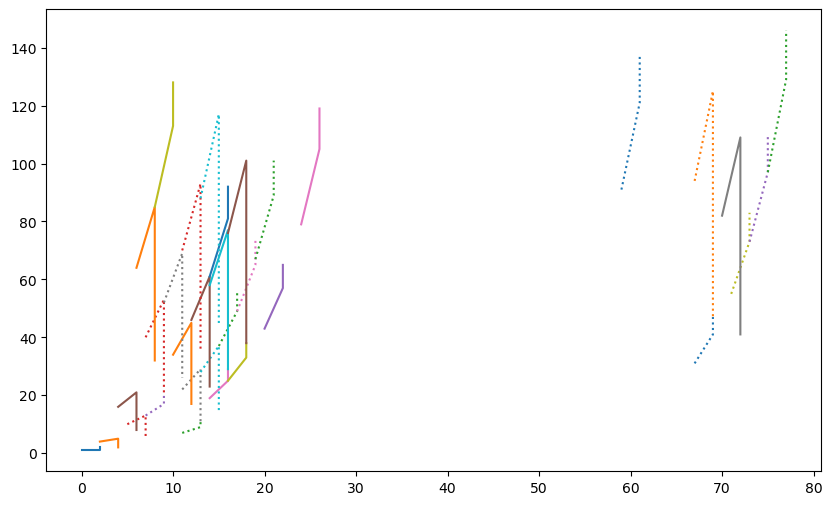

In [323]:
plt.figure(figsize=(10, 6))

for i in range(1, 100):
    T = mrTupFromValue(i)
    label = mrTupToPath(T)
    T_ = G_0(G_1(T))
    val_ = mrTupValue(T_)
    if val_[1] == 1:
        x = len(label)
        X = [x, x+2, x+2]
        if val_[0] % 8 == 1:
            y_111 = (9*val_[0] + 7)//8
        elif val_[0] % 8 == 5:
            y_111 = (3*val_[0] + 1)//8
        Y = [i, val_[0], y_111]
        if x & 1 == 1:
            plt.plot(X, Y, linestyle=":")
        else:
            plt.plot(X, Y)
#
plt.show()

In [294]:
### ^^^ Solid lines are even generations, dotted lines are odd generations

In [279]:
mrTupToLaTex(mrTupFromValue(1))

'$ \\frac{2^{0}}{3^{0}} $'

In [278]:
mrTupToLaTex(mrTupFromValue(4))

'$ \\frac{2^{2}}{3^{0}} $'

In [280]:
mrTupToLaTex(mrTupFromValue(5))

'$ \\frac{2^{4}}{3^{1}} - (   \\frac{2^{0}}{3^{1}} ) $'

$ \Large{ \frac{2^{4}}{3^{1}} - (   \frac{2^{0}}{3^{1}} ) - \frac{2^{2}}{3^{0}} = \frac{2^{0}}{3^{0}} }$

$ 5 - 4 = 1 $

In [292]:
collatzPath(9), collatzPath(7), collatzPath(2)

('0100010110111', '00010110111', '1')

In [293]:
countZeros(collatzPath(9)), countZeros(collatzPath(7))

(6, 5)

In [281]:
mrTupToLaTex(mrTupFromValue(2))

'$ \\frac{2^{1}}{3^{0}} $'

In [282]:
mrTupToLaTex(mrTupFromValue(7))

'$ \\frac{2^{11}}{3^{5}} - (   \\frac{2^{0}}{3^{1}} + \\frac{2^{1}}{3^{2}} + \\frac{2^{2}}{3^{3}} + \\frac{2^{4}}{3^{4}} + \\frac{2^{7}}{3^{5}} ) $'

In [283]:
mrTupToLaTex(mrTupFromValue(9))

'$ \\frac{2^{13}}{3^{6}} - (   \\frac{2^{0}}{3^{1}} + \\frac{2^{2}}{3^{2}} + \\frac{2^{3}}{3^{3}} + \\frac{2^{4}}{3^{4}} + \\frac{2^{6}}{3^{5}} + \\frac{2^{9}}{3^{6}} ) $'

$ \frac{2^{13}}{3^{6}} - ( \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{3}}{3^{3}} + \frac{2^{4}}{3^{4}} + \frac{2^{6}}{3^{5}} + \frac{2^{9}}{3^{6}} ) $

$ - $

$\frac{2^{11}}{3^{5}} - ( \frac{2^{0}}{3^{1}} + \frac{2^{1}}{3^{2}} + \frac{2^{2}}{3^{3}} + \frac{2^{4}}{3^{4}} + \frac{2^{7}}{3^{5}} ) $

$ = $

$\frac{2^{1}}{3^{0}} $

$\frac{2^{13}}{3^{6}} - \frac{2^{11}}{3^{5}}   + (\frac{2^{1}}{3^{2}} - \frac{2^{2}}{3^{2}} ) + (\frac{2^{7}}{3^{5}} - \frac{2^{6}}{3^{5}}) - \frac{2^{9}}{3^{6}}$

$\frac{2^{13}}{3^{6}} - (\frac{3\cdot2^{2}}{3^{2}} ) + (\frac{2^{7}}{3^{5}} - \frac{2^{6}}{3^{5}} - \frac{2^{11}}{3^{5}}) - \frac{2^{9}}{3^{6}}$

$\frac{2^{13}}{3^{6}} - (\frac{2^{2}}{3^{1}} + ( \frac{2^{11}}{3^{5}} + \frac{2^{6}}{3^{5}} - \frac{2^{7}}{3^{5}} )+ \frac{2^{9}}{3^{6}})  $

$\frac{2^{13}}{3^{6}} - (\frac{2^{2}}{3^{1}} + ( \frac{2^{6}}{3^{5}} - \frac{2^{7}}{3^{5}} )+ \frac{2^{9}}{3^{6}} + \frac{2^{11}}{3^{5}} )  $

In [287]:
# val = 2 in thirteenth generation:
mrTupToLaTex(mrTupFromPath("1010101010101"))

'$ \\frac{2^{13}}{3^{6}} - (   \\frac{2^{1}}{3^{1}} + \\frac{2^{3}}{3^{2}} + \\frac{2^{5}}{3^{3}} + \\frac{2^{7}}{3^{4}} + \\frac{2^{9}}{3^{5}} + \\frac{2^{11}}{3^{6}} ) $'

$\frac{2^{13}}{3^{6}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{3}}{3^{2}} + \frac{2^{5}}{3^{3}} + \frac{2^{7}}{3^{4}} + \frac{2^{9}}{3^{5}} + \frac{2^{11}}{3^{6}} )$

In [295]:
# val = 2 in eleventh generation:
mrTupToLaTex(mrTupFromPath("10101010101"))

'$ \\frac{2^{11}}{3^{5}} - (   \\frac{2^{1}}{3^{1}} + \\frac{2^{3}}{3^{2}} + \\frac{2^{5}}{3^{3}} + \\frac{2^{7}}{3^{4}} + \\frac{2^{9}}{3^{5}} ) $'

$ \frac{2^{11}}{3^{5}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{3}}{3^{2}} + \frac{2^{5}}{3^{3}} + \frac{2^{7}}{3^{4}} + \frac{2^{9}}{3^{5}} ) $

In [296]:
collatzPath(13), collatzPath(10), collatzPath(3)

('0110111', '10111', '00111')

'0110111' - '1011101' = '00111'

In [297]:
collatzPath(13), collatzPath(10), collatzPath(3)

('0110111', '10111', '00111')

In [298]:
collatzPath(17), collatzPath(13), collatzPath(4)

('010110111', '0110111', '11')

In [299]:
collatzPath(21), collatzPath(16), collatzPath(5)

('011111', '1111', '0111')

In [300]:
collatzPath(25), collatzPath(19), collatzPath(6)

('0100110010110111', '00110010110111', '100111')

In [301]:
collatzPath(29), collatzPath(22), collatzPath(7)

('0110010110111', '10010110111', '00010110111')

In [302]:
collatzPath(33), collatzPath(25), collatzPath(8)

('010100110010110111', '0100110010110111', '111')

In [303]:
collatzPath(49), collatzPath(37), collatzPath(12)

('01011100010110111', '011100010110111', '1100111')

In [306]:
for i in range(9, 30):
    label = collatzPath(i)
    label_2n = "1" + label
    T_2n = mrTupFromPath(label_2n)
    T_4np1 = mr2Nplus_1(T)
    if T_4np1 is None:
        print(f"{2*i} ({label_2n}) is not '2n+1 Neighborly'")
    else:
        label_4np1 = mrTupToPath(T_4np1)
        label_3np1 = label_4np1[2:]
        print(i, mrTupValue(label_3np1), mrTupValue(label_4np1))

18 (10100010110111) is not '2n+1 Neighborly'
20 (110111) is not '2n+1 Neighborly'
22 (10010110111) is not '2n+1 Neighborly'
24 (11100111) is not '2n+1 Neighborly'
26 (10110111) is not '2n+1 Neighborly'
28 (1100010110111) is not '2n+1 Neighborly'
30 (1000011110111) is not '2n+1 Neighborly'
32 (11111) is not '2n+1 Neighborly'
34 (1010110111) is not '2n+1 Neighborly'
36 (110100010110111) is not '2n+1 Neighborly'
38 (100110010110111) is not '2n+1 Neighborly'
40 (1110111) is not '2n+1 Neighborly'
42 (1011111) is not '2n+1 Neighborly'
44 (110010110111) is not '2n+1 Neighborly'
46 (100011110111) is not '2n+1 Neighborly'
48 (111100111) is not '2n+1 Neighborly'
50 (10100110010110111) is not '2n+1 Neighborly'
52 (110110111) is not '2n+1 Neighborly'
54 (10010000010100100010000101100010010000001100001110101011101100011110111) is not '2n+1 Neighborly'
56 (11100010110111) is not '2n+1 Neighborly'
58 (10110010110111) is not '2n+1 Neighborly'


In [307]:
for i in range(9, 30):
    label = collatzPath(i)
    T = mrTupFromValue(i)
    T_2np1 = mr2Nplus_1(T)
    if T_2np1 is None:
        print(f"{2*i} ({label}) is not '2n+1 Neighborly'")
    else:
        label_2np1 = mrTupToPath(T_2np1)
        label_4np2 =  "1" + label_2np1
        label_3np1 = collatzPath(3*i+1)
        label_4np1 = collatzPath(4*i+1)
        print((i, 3*i+1, 4*i+1, 4*i+2) , (label, label_3np1, label_4np1, label_4np2))

(9, 28, 37, 38) ('0100010110111', '1100010110111', '011100010110111', '100110010110111')
(10, 31, 41, 42) ('10111', '0000010100100010000101100010010000001100001110101011101100011110111', '010000010100100010000101100010010000001100001110101011101100011110111', '1011111')
(11, 34, 45, 46) ('0010110111', '1010110111', '011010110111', '100011110111')
24 (1100111) is not '2n+1 Neighborly'
26 (0110111) is not '2n+1 Neighborly'
(14, 43, 57, 58) ('100010110111', '00101011100010110111', '0100101011100010110111', '10110010110111')
30 (000011110111) is not '2n+1 Neighborly'
32 (1111) is not '2n+1 Neighborly'
(17, 52, 69, 70) ('010110111', '110110111', '01110110111', '10011110111')
(18, 55, 73, 74) ('10100010110111', '00011000010100100010000101100010010000001100001110101011101100011110111', '0100011000010100100010000101100010010000001100001110101011101100011110111', '1011100010110111')
38 (00110010110111) is not '2n+1 Neighborly'
40 (110111) is not '2n+1 Neighborly'
42 (011111) is not '2n+1 Neighb

In [309]:
S = set([])
for i in range(32):
    S.add(3*i + 1)
    S.add(4*i + 1)
for i in range(96):
    if i not in S:
        print(i)
    

0
2
3
6
8
11
12
14
15
18
20
23
24
26
27
30
32
35
36
38
39
42
44
47
48
50
51
54
56
59
60
62
63
66
68
71
72
74
75
78
80
83
84
86
87
90
92
95


# Integers that are not 3N+1 or 4N+1:

Half of all integers:

{n∈Z≥0 ​ : n mod12∈{0,2,3,6,8,11}}

In [320]:

for middle in generationLabels(7):
    label = '011' + middle + '111'
    T = mrTupFromPath(label)
    val = mrTupValue(T)
    if val[1]  == 1:
        label_ = '111' + middle + '111'
        T_ = mrTupFromPath(label_)
        val_ = mrTupValue(T_)
        print((val, val_))
    

((853, 1), (2560, 1))
((277, 1), (832, 1))
((909, 1), (2728, 1))
((301, 1), (904, 1))
((93, 1), (280, 1))
((29, 1), (88, 1))


In [316]:
1024 - 9*113

7

In [321]:
2560 - 3*853

1


010 -> 111:  9n + 7
011 -> 111:  3n + 1